# CMIP6 Future Predictions

## General python imports

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import import_ipynb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns

#niceties
from rich import print

# Needed
from ipywidgets import IntProgress
from IPython.display import display
from scipy.stats import qmc

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Defining the experiment and file paths

In [3]:
# Defining the data period
start_calibration = '1986-11-01'
end_calibration = '2012-10-31'

start_validation = '2012-11-01'
end_validation = '2014-10-31'

future_data_start = '2026-11-01'
future_data_end = '2099-10-31' 

start_hydro_year = 1987
end_hydro_year =2014

start_future_hydro_year = 2027
end_future_hydro_year = 2099

In [4]:
# defining path for catchment shape file
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

# defining destination path for CMIP data
CMIP_folder = Path.home() / "CMIP"
CMIP_folder.mkdir(exist_ok=True)

# model HBV destination path
HBV_model_path = Path.home() / "HBV_model" / "CMIP"
HBV_model_path.mkdir(exist_ok=True)

## Importing the observed data

In [5]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must b converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

In [6]:
# Loading in discharge data from Katima Mulilo
katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
          .drop(columns=['hh:mm'])
          .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

# Creating a dataframe with accessible dates and no invalid data 
katima['Date'] = pd.to_datetime(katima['Date'])
katima['Discharge [m^3/s]'] = katima['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Reducing the dataframe to the calibration period
km = katima[(katima['Date'] >= start_calibration) & (katima['Date'] <= end_validation)]

# Creating a dataframe of the flow data 
flow = pd.DataFrame(data=km['Discharge [m^3/s]'].values, index=km['Date'], columns=['Q'])

## Importing the critical data

In [7]:
Q_crit = (pd.read_csv('Katima_Mulilo/critical_inflow.csv', usecols=[0, 3, 4, 6], delimiter=';', decimal='.')
          .rename(columns={'Year': 'hydro_year', 'Annual Power demand Zambia [MW]': 'power_demand_zambia [MW]', 'Annual Power demand Zimbabwe [MW]': 'power_demand_zimbabwe [MW]', 
                           'Required inflow at Katima Mulilo [m^3/s]': 'Q_crit'}))
Q_crit = Q_crit[(Q_crit['hydro_year'] >= start_hydro_year) & (Q_crit['hydro_year'] <= end_hydro_year)]

## Importing the drought analyser function

In [8]:
from Drought_Function import analyse_annual_deficits_MW

## Generating the forcings

In [9]:
CMIP_dataset = {'dataset': 'MPI-ESM1-2-HR', 'project': 'CMIP6', 'grid' : 'gn', 'exp': 'historical', 'ensemble': 'r1i1p1f1'}

# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=CMIP_dataset,
#    start_time=start_calibration+'T00:00:00Z',
#    end_time=end_validation+'T00:00:00Z',
#    shape=km_shp,
#    directory=CMIP_folder / 'scen_historic',
# )

CMIP_historic = CMIP_folder / "scen_historic" / "work" / "diagnostic" / "script" 
historic = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_historic)

## Running the HBV model (with CMIP6 data)

In [10]:
# Applying the parameters found in the KGE model fit calibration
params_KGE = [5.65179127, 0.27593564, 779.15056566, 2.45298864, 0.04682875, 1.3263829, 0.01356608, 0.0070803, 0.48990002]

# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

In [11]:
model = ewatercycle.models.HBV(forcing=historic)

In [12]:
config_file, _ = model.setup(parameters=params_KGE, initial_storage=s_0, cfg_dir = HBV_model_path)

In [13]:
model.initialize(config_file)

In [14]:
Q_m = []
time = []

while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [15]:
model.finalize()

## Visualising the data

In [16]:
historic_CMIP_output = pd.DataFrame(data=Q_m, index=time, columns=['Q'])
historic_CMIP_output = mmday_to_m3s(historic_CMIP_output, catchment_area_km2)

In [17]:
QCMIP_hist_sim = historic_CMIP_output[start_calibration : end_validation]
QCMIP_hist_obs = flow[start_calibration : end_validation]

QCMIP_hist_sim.index = QCMIP_hist_sim.index.normalize()
QCMIP_hist_obs.index = QCMIP_hist_obs.index.normalize()

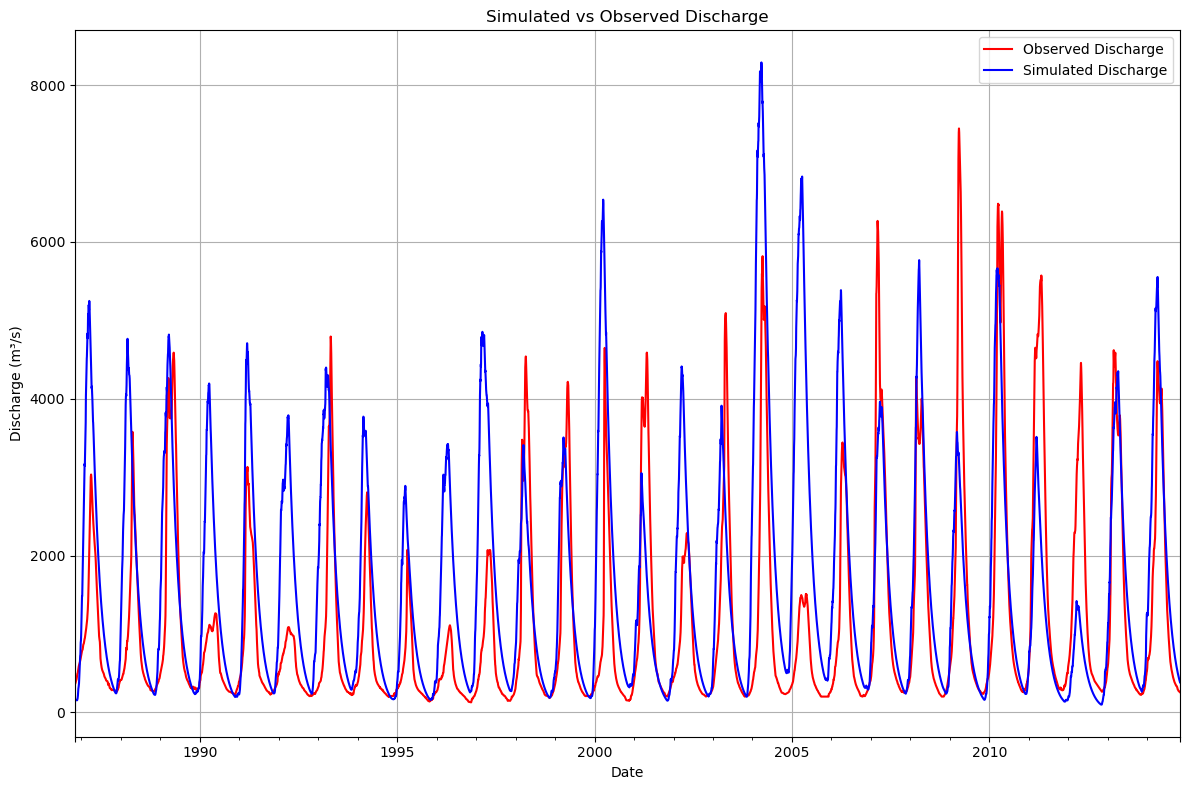

In [18]:
# plot
plt.figure(figsize=(12, 8))

QCMIP_hist_obs['Q'].plot(label="Observed Discharge", color='red')
QCMIP_hist_sim['Q'].plot(label="Simulated Discharge", color='blue')

plt.title('Simulated vs Observed Discharge')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Drought analysis

In [20]:
hist_droughts = QCMIP_hist_obs.reset_index()

hist_droughts['Date'] = pd.to_datetime(hist_droughts['Date'])
hist_droughts['Year'] = hist_droughts['Date'].dt.year
hist_droughts['Day'] = hist_droughts['Date'].dt.dayofyear
hist_droughts['hydro_year'] = np.where(hist_droughts['Day'] < 305, hist_droughts['Year'], hist_droughts['Year'] + 1)

analyse_annual_deficits_MW(hist_droughts, 'Q', Q_crit, 'hydro_year', 'Q_crit', 'power_demand_zambia [MW]', 'power_demand_zimbabwe [MW]')

,hydro_year,avg_net_deficit_m^3/s,power_shortage_MW,Zambia_shortage_%,Zimbabwe_shortage_%
0,1990,229.09,223.50,40.95,24.23
1,1992,329.69,321.65,56.11,33.14
2,1994,146.83,143.25,23.81,14.47
3,1995,404.29,394.43,63.97,39.34
4,1996,505.95,493.61,78.10,48.42
5,1997,246.93,240.90,37.15,23.25
6,2000,63.54,61.99,8.83,5.74
7,2002,147.91,144.30,19.34,13.20
8,2005,376.80,367.61,44.77,32.97
9,2006,49.23,48.03,5.65,4.27
